# PC and GC Experiments

First, import libraries

In [2]:
import vco
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
%matplotlib inline

## Create VCO matrix
As usual, following the examplesin Welday _et al._, 2011.

In [3]:
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

## Create many grid cells:
For each row, all column combos, all cell combos: 6 rows x 4 column combos (12/3) x 12^3 cell combos (~41k grid cells); this is effectively the "fully connected" matrix re: grid cells. Here, however, we only use rows 4 and 5, following evidence (cite?) that suggests that nearby grid cells have similar spacing:

In [4]:
partial_matrix = np.full([6,12,6*4*12**3], np.nan)
jdx = 0
for row in range(6):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    partial_matrix[row,firstcol,  jdx] = cell1
                    partial_matrix[row,firstcol+4,jdx] = cell2
                    partial_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1
                    
print(partial_matrix.shape)

(6, 12, 41472)


## VCO-based Place Cells

place_weights = np.full([6,12],np.nan)
place_weights[3] = 0
place_weights[4] = 11
place_weights[5] = 3

vco.plot_weights(place_weights)

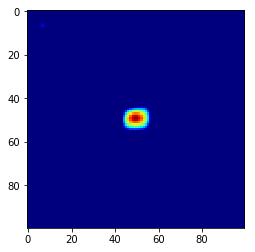

In [102]:
testnorm, testsum = vco.matrix_sum(VCOmat,place_weights,10)

plt.imshow(testnorm,cmap='jet')

In [103]:
n_mats = 25
rd_pweights = np.full([6,12,n_mats], np.nan)

for mat in range(n_mats):
    num_rows = np.random.randint(4) + 1
    for i, w_x in enumerate(np.random.randint(6,size=num_rows)):
        num_change = np.random.randint(8)
        random_cells = np.random.randint(12, size=num_change)
        random_cols = np.random.randint(12, size=num_change)
        rd_pweights[w_x,:,mat] = np.random.randint(12)
        
        for i, col in enumerate(random_cols):
            rd_pweights[w_x, col, mat] = random_cells[i]


In [104]:
size = 10
rd_pnorms = np.zeros((10*size,10*size,n_mats))

In [106]:
for i in range(n_mats):
    pnorm, sumz = vco.matrix_sum(VCOmat, rd_pweights[:,:,i], size)
    rd_pnorms[:,:,i] = pnorm

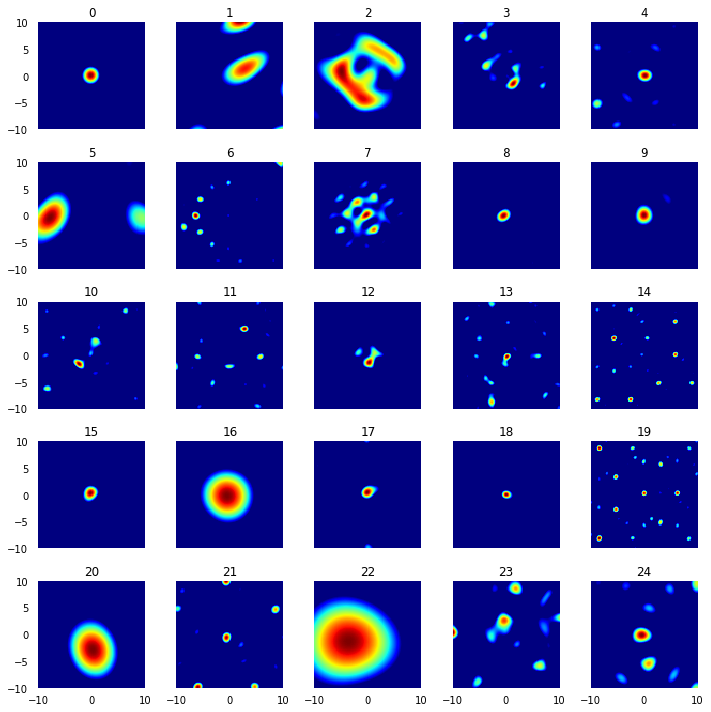

In [107]:
vco.plot_many(rd_pnorms, size)

## Create putative place cells from grid cells with random weights
`num_pc` putative place cells are simulated from the linear summation with random weights of `num_gc` grid cells.

In [39]:
size   = 5
num_gc = 1500
num_pc = 25

rd_gc_mats = np.zeros([6,12,num_gc,num_pc])
pc_outputs = np.zeros([size*10,size*10,num_pc])
gc_outputs = np.zeros([size*10,size*10,num_gc,num_pc])
gc_to_pc_weights = np.zeros([num_gc,num_pc])
for pc in range(num_pc):
    rd_gc_idx = nprd.randint(0,partial_matrix.shape[2],size=num_gc)
    rd_gc_mats[:,:,:,pc] = partial_matrix[:,:,rd_gc_idx]

    for gc in range(num_gc):
        gc_outputs[:,:,gc,pc], _ = vco.matrix_sum(VCOmat, rd_gc_mats[:,:,gc,pc], size)
        gc_to_pc_weights[gc,pc] = nprd.rand()
        pc_outputs[:,:,pc] = pc_outputs[:,:,pc] + gc_to_pc_weights[gc,pc] * gc_outputs[:,:,gc,pc]

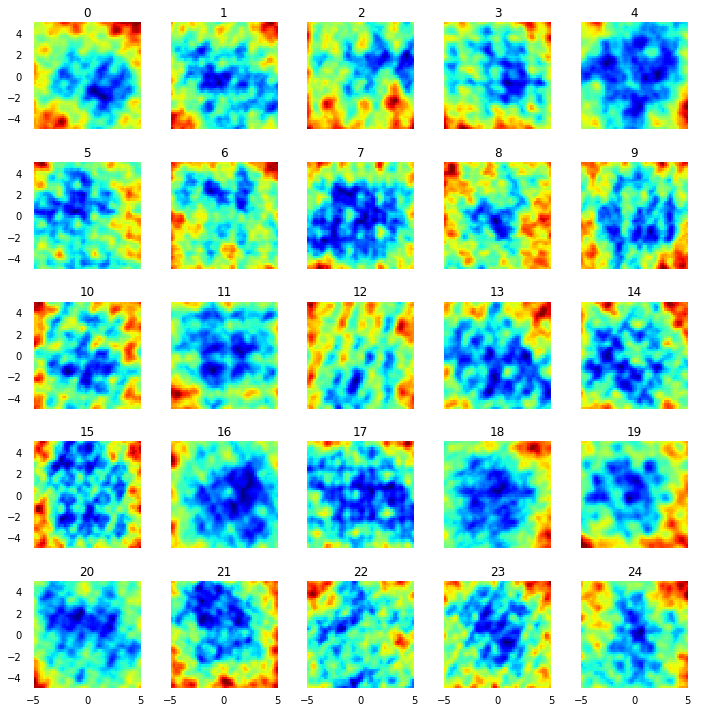

In [40]:
vco.plot_many(pc_outputs,size)

Normalization is implemented as in the original Welday paper, with a threshold at 80% max envelope value.

In [43]:
threshold = 0.8
pc_outputs_norm = np.zeros_like(pc_outputs)
for pc in range(num_pc):
    max_env = np.max(pc_outputs[:,:,pc])
    thr_env = pc_outputs[:,:,pc] - threshold*max_env
    thr_env[thr_env<0] = 0
    max_env = np.max(thr_env)
    pc_outputs_norm[:,:,pc] = thr_env / max_env

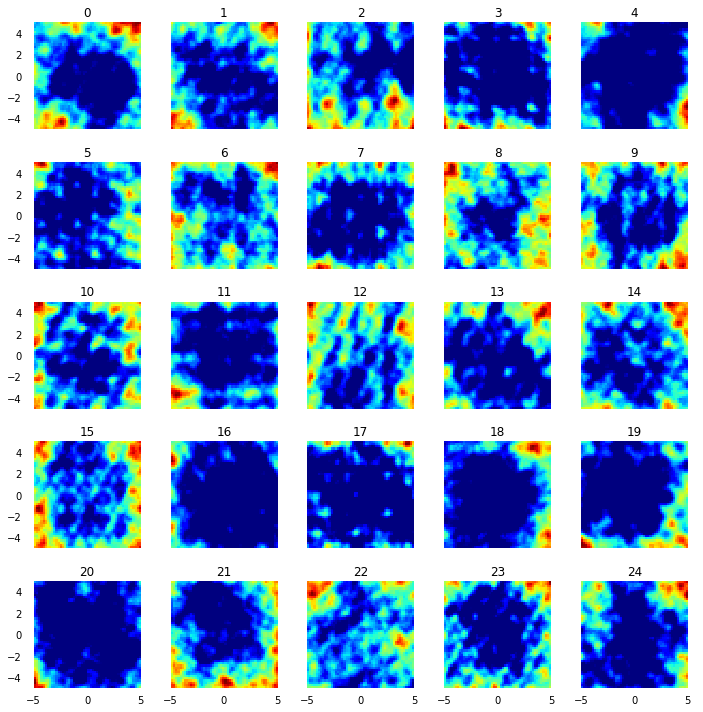

In [44]:
vco.plot_many(pc_outputs_norm, size)

## Shift grid through cell choices
Each ring oscillator determines a particular spatial component of the interference pattern; changing the cell choice in the specified ring oscillators shifts the grid along one of the three axes. This might be useful for an approach like Solstad _et al._.

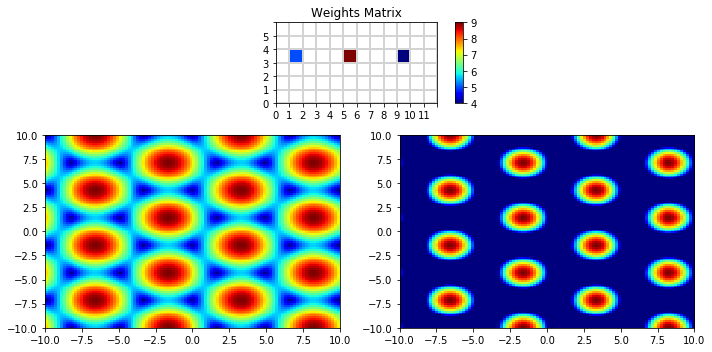

In [32]:
size = 10

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,5] = 9
weights[3,9] = 4

orig_norm, orig_sum = vco.matrix_sum(VCO_matrix, weights, size)
plt.figure(figsize=(10,5))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

plt.tight_layout()

In [80]:
change = 4

weights_al = np.copy(weights)
weights_al[3,1] = weights[3,1] - change
al_norm, al_sum = vco.matrix_sum(VCO_matrix,weights_al,size)

weights_ag = np.copy(weights)
tmp_ag = weights[3,1] + change
if tmp_ag >= ringsize:
    tmp_ag = tmp_ag - ringsize
weights_ag[3,1] = tmp_ag
ag_norm, ag_sum = vco.matrix_sum(VCO_matrix,weights_ag,size)

weights_bl = np.copy(weights)
weights_bl[3,5] = weights[3,5] - change
bl_norm, bl_sum = vco.matrix_sum(VCO_matrix,weights_bl,size)

weights_bg = np.copy(weights)
tmp_bg = weights[3,5] + change
if tmp_bg >= ringsize:
    tmp_bg = tmp_bg - ringsize
weights_bg[3,5] = tmp_bg
bg_norm, bg_sum = vco.matrix_sum(VCO_matrix,weights_bg,size)

weights_cl = np.copy(weights)
weights_cl[3,9] = weights[3,9] - change
cl_norm, cl_sum = vco.matrix_sum(VCO_matrix,weights_cl,size)

weights_cg = np.copy(weights)
tmp_cg = weights[3,9] + change
if tmp_cg >= ringsize:
    tmp_cg = tmp_cg - ringsize
weights_cg[3,9] = tmp_cg
cg_norm, cg_sum = vco.matrix_sum(VCO_matrix,weights_cg,size)

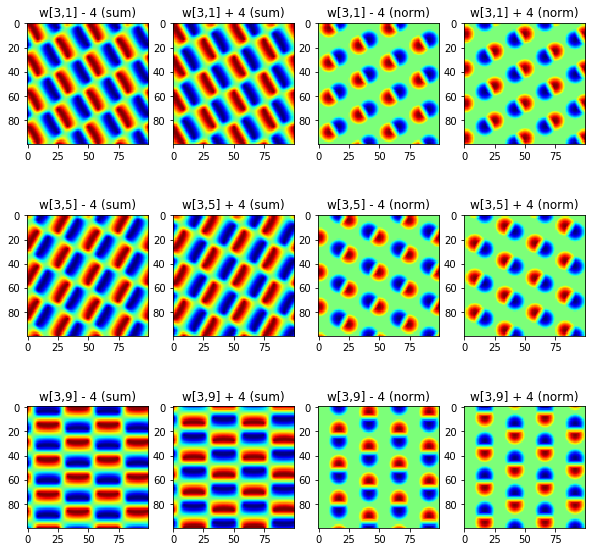

In [81]:
plt.figure(figsize=(10,10))
plt.subplot(3,4,1)
plt.title('w[3,1] - %d (sum)' % change)
plt.imshow(al_sum - orig_sum,cmap='jet')
plt.subplot(3,4,2)
plt.title('w[3,1] + %d (sum)' % change)
plt.imshow(ag_sum - orig_sum,cmap='jet')
plt.subplot(3,4,3)
plt.title('w[3,1] - %d (norm)' % change)
plt.imshow(al_norm - orig_norm,cmap='jet')
plt.subplot(3,4,4)
plt.title('w[3,1] + %d (norm)' % change)
plt.imshow(ag_norm - orig_norm,cmap='jet')
plt.subplot(3,4,5)
plt.title('w[3,5] - %d (sum)' % change)
plt.imshow(bl_sum - orig_sum,cmap='jet')
plt.subplot(3,4,6)
plt.title('w[3,5] + %d (sum)' % change)
plt.imshow(bg_sum - orig_sum,cmap='jet')
plt.subplot(3,4,7)
plt.title('w[3,5] - %d (norm)' % change)
plt.imshow(bl_norm - orig_norm,cmap='jet')
plt.subplot(3,4,8)
plt.title('w[3,5] + %d (norm)' % change)
plt.imshow(bg_norm - orig_norm,cmap='jet')
plt.subplot(3,4,9)
plt.title('w[3,9] - %d (sum)' % change)
plt.imshow(cl_sum - orig_sum,cmap='jet')
plt.subplot(3,4,10)
plt.title('w[3,9] + %d (sum)' % change)
plt.imshow(cg_sum - orig_sum,cmap='jet')
plt.subplot(3,4,11)
plt.title('w[3,9] - %d (norm)' % change)
plt.imshow(cl_norm - orig_norm,cmap='jet')
plt.subplot(3,4,12)
plt.title('w[3,9] + %d (norm)' % change)
plt.imshow(cg_norm - orig_norm,cmap='jet')


In [85]:
weights_minus = np.copy(weights)
weights_minus[3,1] = weights[3,1] - change/2
weights_minus[3,5] = weights[3,5] - change
weights_minus[3,9] = weights[3,9] - change
minus_norm, minus_sum = vco.matrix_sum(VCO_matrix,weights_minus,size)

weights_plus = np.copy(weights)
tmp1 = weights[3,1] + change/2
tmp5 = weights[3,5] + change
tmp9 = weights[3,9] + change
if tmp1 >= ringsize:
    tmp1 = tmp1 - ringsize
if tmp5 >= ringsize:
    tmp5 = tmp5 - ringsize
if tmp9 >= ringsize:
    tmp9 = tmp9 - ringsize
    
weights_plus[3,1] = tmp1
weights_plus[3,5] = tmp5
weights_plus[3,9] = tmp9
plus_norm, plus_sum = vco.matrix_sum(VCO_matrix,weights_plus,size)

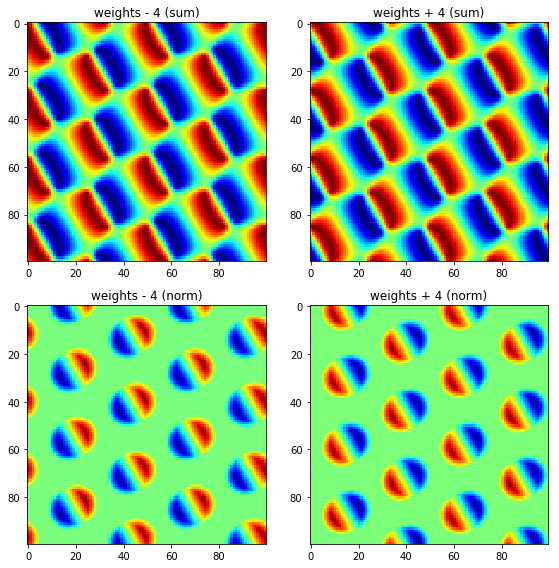

In [86]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title('weights - %d (sum)' % change)
plt.imshow(minus_sum - orig_sum,cmap='jet')
plt.subplot(2,2,2)
plt.title('weights + %d (sum)' % change)
plt.imshow(plus_sum - orig_sum,cmap='jet')
plt.subplot(2,2,3)
plt.title('weights - %d (norm)' % change)
plt.imshow(minus_norm - orig_norm,cmap='jet')
plt.subplot(2,2,4)
plt.title('weights + %d (norm)' % change)
plt.imshow(plus_norm - orig_norm,cmap='jet')
plt.tight_layout()

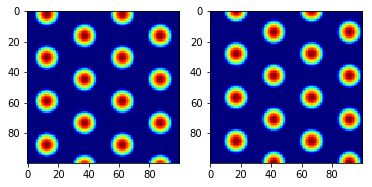

In [89]:
plt.subplot(121); plt.imshow(plus_norm,cmap='jet')
plt.subplot(122); plt.imshow(orig_norm,cmap='jet')

It's impossible to visually see a significant difference here, but we can definitely shift the grid (a la Solstad _et al._) by altering VCO cell choice.